<a href="https://colab.research.google.com/github/aminasadikovic/ODP-App/blob/main/Projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cilj ovog projekta je izraditi model mašinskog učenja koji predviđa cijenu polovnih mobilnih telefona na osnovu informacija prikupljenih sa online platforme za prodaju.

Podaci su prikupljeni, analizirani, očišćeni i podijeljeni na odgovarajuće skupove za treniranje i testiranje modela.

U okviru projekta korišteni su linearna regresija i polinomijalna regresija, a rezultati ovih modela su upoređeni na osnovu metrika kao što su MAE, RMSE i R².


In [7]:
# Uvoz potrebnih biblioteka za rad s podacima i vizualizaciju
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Učitavanje skupa podataka iz CSV fajla
data = pd.read_csv("sample_data/smartphones_with_mobile_id (1).csv", delimiter=",")


In [8]:
# Kolona koju želimo mapirati
varlist = ['operatingSystem']

# Funkcija koja mapira tekstualne vrijednosti u numeričke (iOS -> 0, Android -> 1)
def os_map(x):
    return x.map({'iOS': 0, "Android": 1})

# Primjena mapiranja na odabrane kolone u dataframe-u
data[varlist] = data[varlist].apply(os_map)


In [9]:
# Funkcija za čišćenje vrijednosti memorije (RAM, storage) i pretvaranje u GB
def clean_memory(val):
    if pd.isna(val):
        return np.nan
    val = str(val).lower().replace(" ", "")
    for unit in ['tb', 'gb', 'mb']:
        if unit in val:
            try:
                num = float(val.replace(unit, ''))
                if unit == 'tb':
                    return num * 1024      # TB se pretvara u GB
                elif unit == 'mb':
                    return num / 1024      # MB se pretvara u GB
                return num                 # GB ostaje nepromijenjeno
            except:
                return np.nan
    try:
        return float(val)  # Ako nema jedinice, pokušava se direktno parsirati
    except:
        return np.nan

# Funkcija za čišćenje veličine ekrana, uklanjanje 'in' i pretvaranje u float
def clean_inches(val):
    if pd.isna(val):
        return np.nan
    val = str(val).lower().replace("in", "").strip()
    try:
        return float(val)
    except:
        return np.nan

# Funkcija za čišćenje vrijednosti kamere, uklanjanje 'MP' i pretvaranje u float
def clean_camera(val):
    if pd.isna(val):
        return np.nan
    val = str(val).lower().replace("mp", "").strip()
    try:
        return float(val)
    except:
        return np.nan

# Čišćenje kolona za memoriju (RAM i storage)
varlist_memory = ['storage', 'ram']
for col in varlist_memory:
    data[col] = data[col].map(clean_memory)


# Čišćenje kolona za veličinu ekrana i kameru
data['screenSize'] = data['screenSize'].map(clean_inches)
data['camera'] = data['camera'].map(clean_camera)

# Prije primjene funkcija za čišćenje, neki podaci su već sadržavali `NaN` vrijednosti, dok su ostali bili nepravilno zapisani (npr. "64 GB", "1 TB", "12MP", "6.1in", itd).
# Nakon transformacije i konverzije u numerički format, broj `NaN` vrijednosti se dodatno povećao jer su sve nepravilne ili neprepoznate vrijednosti zamijenjene sa `np.nan`.


In [10]:
# Rječnik koji mapira tip procesora u broj jezgri
processor_map = {
    'single core': 1,
    'dual core': 2,
    'triple core': 3,
    'quad core': 4,
    'penta core': 5,
    'hexa core': 6,
    'hepta core': 7,
    'octa core': 8,
    'nona core': 9,
    'deca core': 10
}

# Funkcija koja traži ključne riječi u stringu i vraća broj jezgri
def map_processor(val):
    if pd.isna(val):
        return np.nan  # Ako je prazno, ostaje NaN
    val = str(val).lower().strip()  # Pretvori u mala slova i ukloni razmake
    for key in processor_map:
        if key in val:
            return processor_map[key]  # Vraća broj jezgri prema rječniku
    return np.nan  # Ako nijedan ključ nije pronađen

# Primjena mapiranja na kolonu 'processor'
data['processor'] = data['processor'].map(map_processor)


In [11]:
# Uvoz biblioteka
import pandas as pd
from sklearn.impute import SimpleImputer

# Lista numeričkih kolona za koje ćemo koristiti srednju vrijednost za imputaciju
# Koristimo srednju vrijednost jer su ove kolone numeričke i kontinualne,
# pa je to prirodan način popunjavanja nedostajućih vrijednosti bez velikog uticaja na raspodjelu podataka.
mean_impute_cols = ['storage', 'ram', 'camera', 'screenSize', 'processor']

# 1. Imputacija NaN vrijednosti srednjom vrijednošću (mean) za odabrane kolone
mean_imputer = SimpleImputer(strategy='mean')
data[mean_impute_cols] = mean_imputer.fit_transform(data[mean_impute_cols])

# 2. Za sve ostale kolone koje nisu u gornjoj listi, NaN vrijednosti se popunjavaju nulom
remaining_cols = [col for col in data.columns if col not in mean_impute_cols]
data[remaining_cols] = data[remaining_cols].fillna(-1)


In [12]:
import pandas as pd
import re
from sklearn.preprocessing import OneHotEncoder

data = data.copy()
# Uklanjanje duplikata iz podataka
data = data.drop_duplicates()

# Funkcija za čišćenje naziva modela
def clean_model_name(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\(.*?\)', '', text)  # ukloni tekst u zagradama
    text = re.sub(r'[^a-z0-9 ]', ' ', text)  # zamijeni specijalne znakove razmakom
    text = re.sub(
        r'\b(used|new|sealed|unlocked|black|white|blue|green|silver|gold|gray|grey|128gb|256gb|512gb|1tb|64gb|5g|4g|duos|pro|max|ultra|plus)\b',
        '', text
    )  # uklanja riječi koje ne razlikuju model
    text = re.sub(r'\s+', ' ', text).strip()  # višestruki razmaci → jedan razmak
    return text

# Dodavanje nove kolone sa očišćenim modelima
data.loc[:, 'clean_model'] = data['model'].apply(clean_model_name)

# Funkcija za grupisanje modela
def group_model(text):
    if "iphone" in text:
        if 'iphone se' in text:
            return 'iphone se'
        if 'iphone xr' in text:
            return 'iphone xr'
        if 'iphone xs max' in text:
            return 'iphone xs max'
        if 'iphone xs' in text:
            return 'iphone xs'
        if 'iphone x' in text:
            return 'iphone x'
        for i in range(7, 17):
            if f'iphone {i}' in text:
                return f'iphone {i}'
    if "galaxy" in text or "samsung" in text:
        if "s" in text:
            match = re.search(r's\s?(1[0-9]|[2-9])\b', text)
            if match:
                return f'galaxy s{match.group(1)}'
        return 'galaxy other'
    if "xiaomi" in text or "redmi" in text or "poco" in text:
        return 'xiaomi'
    return 'other'

# Dodavanje kolone sa grupisanim modelima
data.loc[:, 'grouped_model'] = data['clean_model'].apply(group_model)

# Funkcija za čišćenje brenda
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9 ]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

# Dodavanje nove kolone sa očišćenim nazivima brenda
data.loc[:, 'clean_brand'] = data['brand'].apply(clean_text)

# One-hot encoding za brend
brand_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
brand_ohe.fit(data[['clean_brand']])


OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [13]:
from sklearn.model_selection import train_test_split

# Lista kolona koje ćemo ignorisati u treningu jer nisu korisne za model
ignore_columns = [
    'item_web_url', 'title', 'model', 'currency', 'battery',
    'wirelessCharging', 'displayResolution', 'displayTechnology',
    'waterResistance', 'model_id', 'brand',
    'clean_model', 'grouped_model', 'clean_brand', 'operatingSystem'
]

# Podjela skupa podataka na trening (70%) i test (30%)
df_train, df_test = train_test_split(data, test_size=0.3, random_state=42)

# Resetujemo indekse kako bismo dobili čiste DataFrame-ove bez starih indeksa
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

train_size = len(df_train)
test_size = len(df_test)

print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

Training set size: 401
Test set size: 173


One-Hot Encoding je tehnika kojom se kategorizirane (diskretne) vrijednosti pretvaraju u numerički format pogodan za strojno učenje. Svaka jedinstvena kategorija se pretvara u zasebnu binarnu (0/1) kolonu.

In [14]:
# One-hot enkodiranje branda u trening i test skupu
X_brand_train = brand_ohe.transform(df_train[['clean_brand']])
X_brand_test = brand_ohe.transform(df_test[['clean_brand']])

# One-hot enkodiranje ID-ja (mobilnog uređaja) — može pomoći kod personalizacije modela
id_ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_id_train = id_ohe.fit_transform(df_train[['mobile_id']])  # Treniraj encoder na trening skupu
X_id_test = id_ohe.transform(df_test[['mobile_id']])        # Primijeni na test skupu

# 1. Izračunaj prosječnu cijenu za svaki brand (korisno kao dodatna numerička feature)
brand_avg_price = data.groupby('clean_brand')['price'].mean()

# 2. Dodaj kolonu s prosječnom cijenom branda u trening i test skup
df_train['brand_avg_price'] = df_train['clean_brand'].map(brand_avg_price)
df_test['brand_avg_price'] = df_test['clean_brand'].map(brand_avg_price)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicijalizacija TF-IDF vektorizatora sa maksimalno 50 značajki za grupisane modele
model_vectorizer = TfidfVectorizer(max_features=50)
model_vectorizer.fit(data['grouped_model'])  # Uči vokabular na cijelom datasetu

# Transformacija grupisanih modela u TF-IDF numeričke vektore za trening i test skupove
X_model_train = model_vectorizer.transform(df_train['grouped_model'])
X_model_test = model_vectorizer.transform(df_test['grouped_model'])

# Izvlačenje numeričkih (kontinuiranih) kolona za trening i test (bez ignorisanih kolona i ciljne varijable)
X_train_numeric = df_train.drop(columns=ignore_columns + ['price', 'mobile_id']).values
X_test_numeric = df_test.drop(columns=ignore_columns + ['price', 'mobile_id']).values


In [16]:
from sklearn.preprocessing import RobustScaler

# Inicijalizacija RobustScaler-a za skaliranje numeričkih podataka
# RobustScaler je otporan na outliere jer koristi medijanu i interkvartilni raspon
scaler = RobustScaler()

# Prilagođavanje skalera na trening podacima i transformacija
X_train_numeric = scaler.fit_transform(X_train_numeric)

# Transformacija test podataka koristeći isti scaler (bez ponovnog fitovanja)
X_test_numeric = scaler.transform(X_test_numeric)


In [17]:
from scipy.sparse import hstack

# Spajanje numeričkih i enkodiranih feature-a u jednu zajedničku sparse matricu za trening i test
# hstack omogućava horizontalno spajanje različitih tipova podataka (dense i sparse)
X_train = hstack([X_train_numeric, X_brand_train, X_model_train, X_id_train])
X_test = hstack([X_test_numeric, X_brand_test, X_model_test, X_id_test])

# Ciljna varijabla - log-transformisana cijena (log1p koristi log(1 + x) da izbjegne probleme s nulama)
# Log transformacija pomaže u stabilizaciji varijanse i bolje ponašanje modela
y_train = np.log1p(df_train['price'].values)
y_test = np.log1p(df_test['price'].values)


In [18]:
# 10. Kreiranje i treniranje Ridge regresionog modela sa regularizacijom alpha=1.0
# Koristimo log-transformisanu ciljnu varijablu zbog velike varijabilnosti cijena
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error

ridge = Ridge(alpha=1.0)  # Možeš probati i druge vrijednosti alpha za podešavanje regularizacije
ridge.fit(X_train, y_train)

# 11. Predikcija na test skupu u log-prostoru
y_pred_log = ridge.predict(X_test)

# Inverzna transformacija predikcija iz log-prostora u originalne cijene
y_pred = np.expm1(y_pred_log)  # exp(pred) - 1
y_true = np.expm1(y_test)

# 12. Evaluacija modela
# R² metrički pokazatelj u log-prostoru (konsistentan sa treningom)
r2 = r2_score(y_test, y_pred_log)

# MAPE (Mean Absolute Percentage Error) u originalnom prostoru cijena
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"R² (log-space): {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


R² (log-space): 0.8345
MAPE: 23.09%


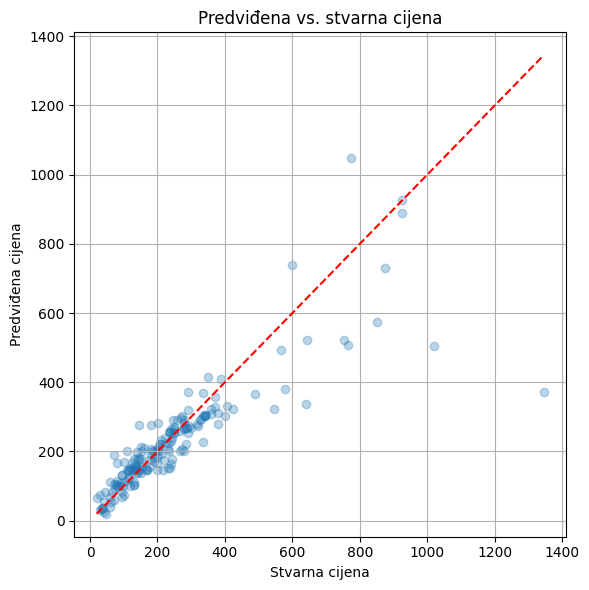

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Stvarna cijena')
plt.ylabel('Predviđena cijena')
plt.title('Predviđena vs. stvarna cijena')
plt.grid(True)
plt.tight_layout()
plt.show()


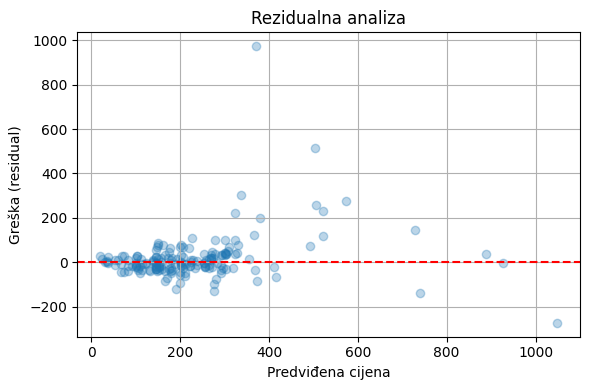

In [20]:
# Izračun reziduala (razlika između stvarnih i predviđenih vrijednosti)
residuals = y_true - y_pred

# Plot rezidualne analize: reziduali naspram predviđenih vrijednosti
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)  # tačke sa transparentnošću za preglednost
plt.axhline(0, color='red', linestyle='--')  # horizontalna linija na nuli za vizuelnu referencu
plt.xlabel('Predviđena cijena')
plt.ylabel('Greška (residual)')
plt.title('Rezidualna analiza')
plt.grid(True)
plt.tight_layout()
plt.show()


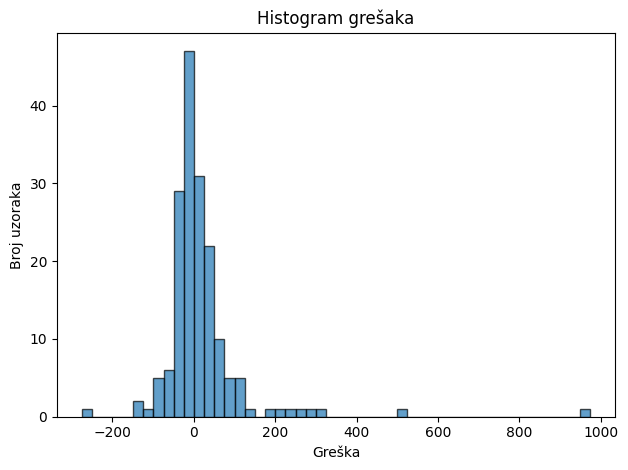

In [21]:
# Histogram reziduala (grešaka) modela
# Prikazuje distribuciju grešaka kako bismo vidjeli njihovu raspodjelu
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram grešaka')
plt.xlabel('Greška')
plt.ylabel('Broj uzoraka')
plt.tight_layout()
plt.show()


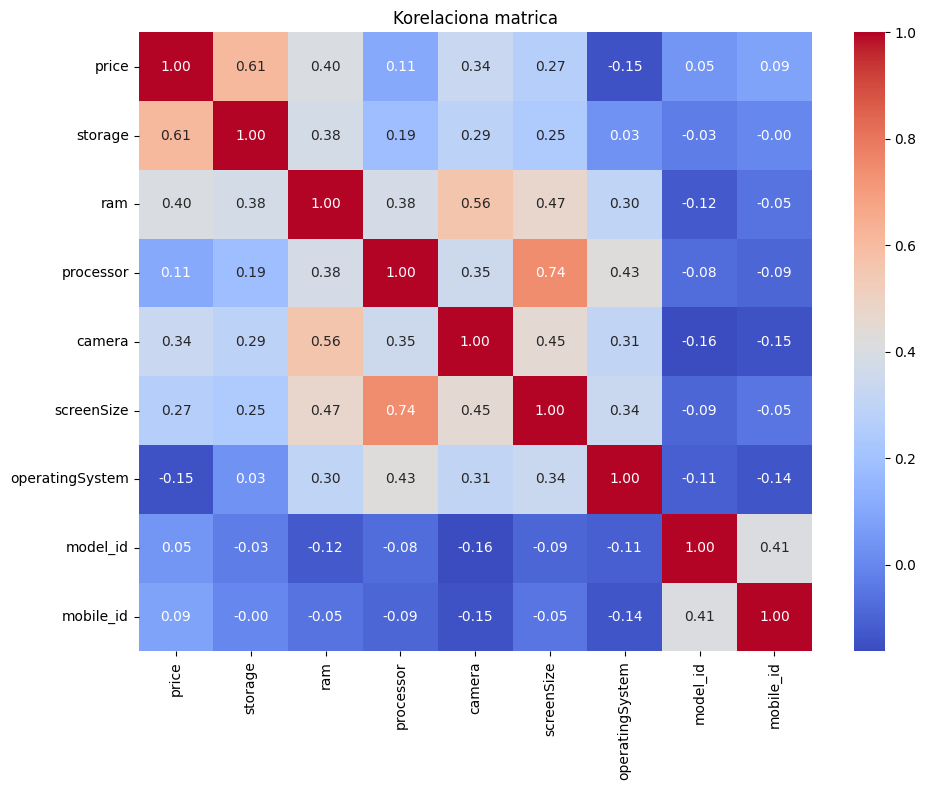

In [22]:
# Selektovanje numeričkih kolona iz podataka, osim određenih koje nisu relevantne ili su kategorijske
numerics = data.select_dtypes(include=['float64', 'int64']).drop(columns=['releaseYear', 'wirelessCharging', 'displayResolution', 'waterResistance'])

# Izračunavanje korelacione matrice između numeričkih varijabli
correlation_matrix = numerics.corr()

# Prikaz korelacione matrice kao toplinske mape sa anotacijama
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelaciona matrica")
plt.tight_layout()
plt.show()


**Osvrt na linearni model:**

Linearni model je jednostavan i često dobar početak za regresione zadatke. On pretpostavlja linearnu vezu između ulaznih karakteristika i ciljne varijable, što olakšava interpretaciju i brzo treniranje. Međutim, kod složenijih podataka, poput cijena telefona koje mogu zavisiti od nelinearnih faktora, linearni model može imati ograničenja u preciznosti.

U našem slučaju, linearni Ridge model sa regularizacijom je dobro uhvatio osnovne trendove, ali ostaje prostor za poboljšanje u hvatanju složenijih odnosa među karakteristikama. Zato ćemo sada isprobati polinomijalni model koji može bolje da modelira nelinearnosti.

Prije primjene polinomijalne transformacije, koristimo MaxAbsScaler kako bismo sve karakteristike doveli u opseg od
[−1,1].
MaxAbsScaler ne mijenja nulu i zadržava rjeđe vrijednosti netaknutim, što ga čini pogodnim za kombinovanje različitih izvora podataka (npr. kombinaciju numeričkih, binarnih i tekstualnih feature-a). Ovo skaliranje je bilo ključno za stabilnost i uspjeh našeg polinomijalnog modela.

In [23]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
print(X_train.shape)

X_test = scaler.transform(X_test)
print(X_test.shape)


(401, 151)
(173, 151)


U nastavku koristimo isti skup koraka za pripremu podataka kao i kod linearnog modela — uključujući transformaciju kategorijskih podataka, ekstrakciju i skaliranje numeričkih vrijednosti, te spajanje svih značajki u konačne matrice za treniranje i testiranje.

Pretvaranje sparse matrica u dense format (ako je potrebno):
Ako su naši podaci u sparse formatu (rijetke matrice), prvo ih pretvaramo u dense format kako bismo mogli primijeniti imputaciju i polinomijalne transformacije.

Polinomijalna ekspanzija:
Koristimo PolynomialFeatures da bismo stvorili nove značajke koje su kombinacije postojećih, do stepena 3, čime modelu omogućavamo hvatanje složenijih nelinearnih odnosa.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

deg = 3

# Pretvaranje sparse matrica u dense ako je potrebno
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Direktno radimo s već popunjenim vrijednostima
poly = PolynomialFeatures(degree=deg, include_bias=False)
x_train_poly_features = poly.fit_transform(X_train_dense)
x_test_poly_features = poly.transform(X_test_dense)


Koristimo Ridge regresiju umjesto obične linearne regresije zato što radimo s polinomijalnim značajkama, pri čemu se broj kolona (ulaznih varijabli) znatno povećava. Uzimajući u obzir više značajki, model postaje složeniji i sklon prenaučenosti (overfittingu).

Ridge regresija koristi L2 regularizaciju, što znači da dodaje kaznu na velike vrijednosti koeficijenata i time smanjuje kompleksnost modela. Na taj način, Ridge pomaže modelu da bolje generalizuje na nove podatke.

In [25]:
# Kreiranje i treniranje Ridge regresije na polinomijalnim značajkama
poly_reg_model = Ridge(alpha=1.0)
poly_reg_model.fit(x_train_poly_features, y_train)


Ridge()

In [26]:
from sklearn.metrics import mean_absolute_error
# Izračunavamo srednju apsolutnu grešku (MAE) na trening i test skupu kako bismo procijenili
# koliko dobro model pristaje podacima i koliko se generalizuje na nove, neviđene primjere.

y_train_pred = poly_reg_model.predict(x_train_poly_features)
mean_absolute_error(y_train, y_train_pred)
y_test_pred = poly_reg_model.predict(x_test_poly_features)
mean_absolute_error(y_test, y_test_pred)
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))


Train MAE: 0.11391099233561074
Test MAE: 0.19589588068887842


In [27]:
# Ako je X_train u sparse formatu, pretvorimo ga u dense matricu radi lakše obrade.
# Zatim sortiramo uzorke po vrijednostima prve osobine (prva kolona) kako bismo mogli
# preglednije vizualizirati rezultate poređenjem stvarnih i predviđenih vrijednosti.

X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train

sorted_indices = np.argsort(X_train_dense[:, 0])

# Primijeni sortirane indekse na podatke i rezultate modela
X_train_sorted = X_train_dense[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_train_pred_sorted = y_train_pred[sorted_indices]


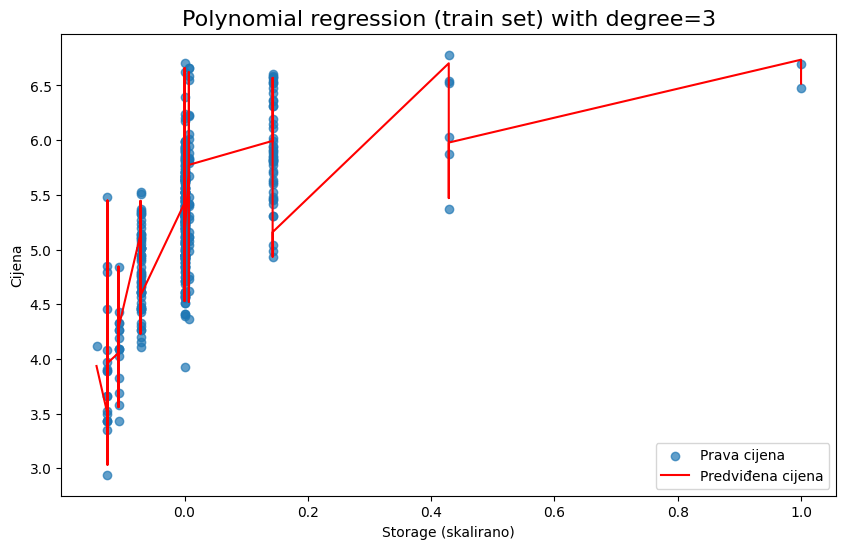

In [28]:
# Ovaj graf pokazuje koliko dobro polinomijalni model
# prati stvarne cijene u zavisnosti od skladišnog kapaciteta uređaja (storage).

plt.figure(figsize=(10, 6))
plt.title(f"Polynomial regression (train set) with degree={deg}", size=16)

# Prikazujemo stvarne cijene kao tačke, prema vrijednostima prve osobine (storage)
plt.scatter(X_train_sorted[:, 0], y_train_sorted, label="Prava cijena", alpha=0.7)

# Crvenom linijom prikazujemo predviđene cijene modela na osnovu iste osobine
plt.plot(X_train_sorted[:, 0], y_train_pred_sorted, c="red", label="Predviđena cijena")

plt.xlabel("Storage (skalirano)")
plt.ylabel("Cijena")
plt.legend()
plt.show()


In [29]:
# Izvući prvu osobinu iz test skupa i pretvoriti u običan niz
first_feature = X_test[:, 0].toarray().flatten()

# Dobiti indekse koji sortiraju test podatke po vrijednosti prve osobine
sorted_indices = np.argsort(first_feature)

# Sortirati test podatke, stvarne ciljne vrijednosti i predviđene vrijednosti po tim indeksima
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_test_pred_sorted = y_test_pred[sorted_indices]


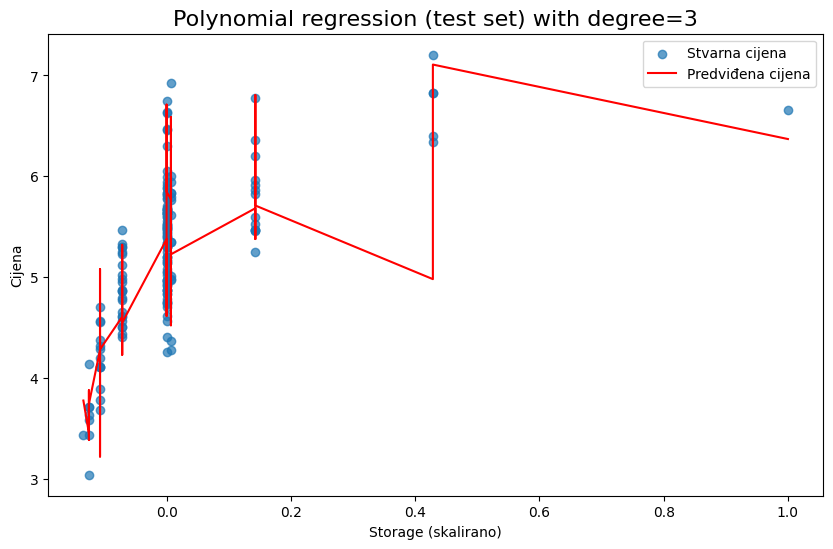

In [30]:
# Izvući prvu kolonu iz sortirane sparse matrice i pretvoriti u numpy array
X_test_sorted_array = X_test_sorted[:, 0].toarray().flatten()

plt.figure(figsize=(10, 6))
plt.title(f"Polynomial regression (test set) with degree={deg}", size=16)
plt.scatter(X_test_sorted_array, y_test_sorted, alpha=0.7, label="Stvarna cijena")
plt.plot(X_test_sorted_array, y_test_pred_sorted, c="red", label="Predviđena cijena")
plt.xlabel("Storage (skalirano)")
plt.ylabel("Cijena")
plt.legend()
plt.show()



In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("R^2:", r2_score(y_test, y_test_pred))

# Relativna greška (MAPE)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")


R^2: 0.831245053806929
MAPE: 3.92%


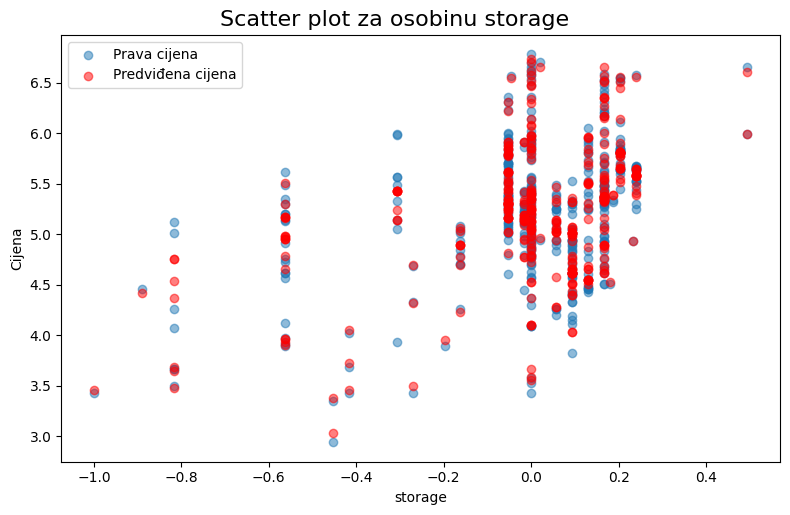

In [32]:
mean_impute_cols = ['storage']

feature_indices = [data.columns.get_loc(col) for col in mean_impute_cols]

fig, axs = plt.subplots(len(mean_impute_cols), 1, figsize=(8, 5))

for i, col_idx in enumerate(feature_indices):
    axs.scatter(X_train_sorted[:, col_idx], y_train_sorted, alpha=0.5, label='Prava cijena')
    axs.scatter(X_train_sorted[:, col_idx], y_train_pred_sorted, color='red', alpha=0.5, label='Predviđena cijena')
    axs.set_xlabel(mean_impute_cols[i])
    axs.set_ylabel("Cijena")
    axs.legend()

plt.tight_layout()
plt.suptitle("Scatter plot za osobinu storage", fontsize=16, y=1.02)
plt.show()


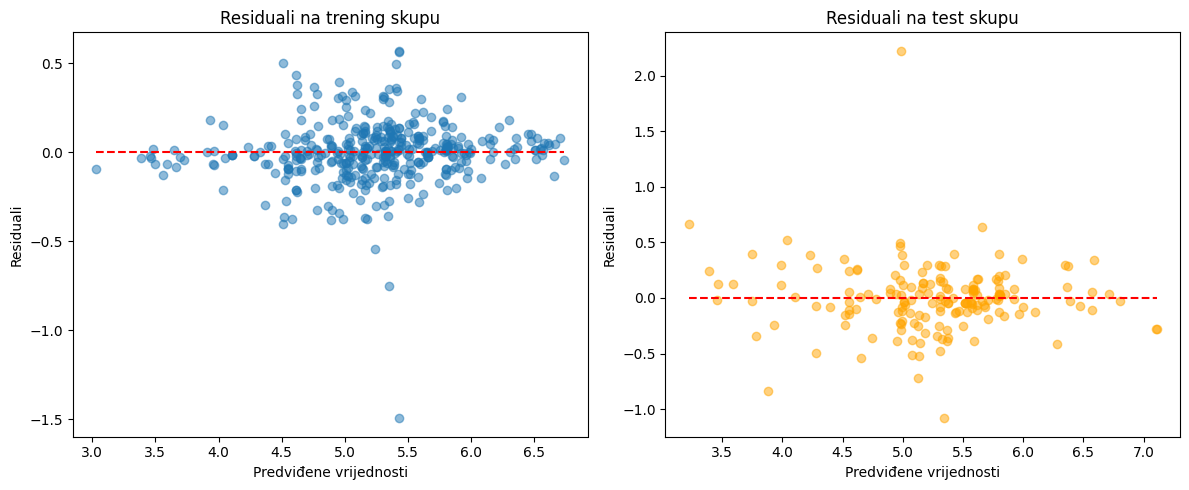

In [33]:
# Grafikon residuala pomaže da vizualno provjerimo kvalitet modela.
# Ravnomjerna raspodjela residuala oko nule bez očiglednih obrazaca ukazuje na dobar fit modela

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train_pred, residuals_train, alpha=0.5)
plt.hlines(y=0, xmin=min(y_train_pred), xmax=max(y_train_pred), colors='r', linestyles='--')
plt.title('Residuali na trening skupu')
plt.xlabel('Predviđene vrijednosti')
plt.ylabel('Residuali')

plt.subplot(1,2,2)
plt.scatter(y_test_pred, residuals_test, alpha=0.5, color='orange')
plt.hlines(y=0, xmin=min(y_test_pred), xmax=max(y_test_pred), colors='r', linestyles='--')
plt.title('Residuali na test skupu')
plt.xlabel('Predviđene vrijednosti')
plt.ylabel('Residuali')

plt.tight_layout()
plt.show()


In [34]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Definiraj pipeline s imputacijom, polinomijalnim značajkama i Ridge regresijom
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge(alpha=1.0))
])

# Izračunaj cross-validaciju s 5 foldova (možeš mijenjati broj cv)
scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)

# Negativne vrijednosti pretvori u pozitivne MAE vrijednosti
mae_scores = -scores

print(f"MAE na pojedinačnim foldovima: {mae_scores}")
print(f"Prosječni MAE: {np.mean(mae_scores):.4f}")
print(f"Standardna devijacija MAE: {np.std(mae_scores):.4f}")


MAE na pojedinačnim foldovima: [0.22412117 0.27431763 0.23956541 0.2126017  0.24989288]
Prosječni MAE: 0.2401
Standardna devijacija MAE: 0.0213


Nakon upoređivanja rezultata na trening i test skupu, kao i rezultata dobijenih unakrsnom validacijom (cross-validation), možemo zaključiti da model nije overfit-an. Trening MAE iznosi oko 0.114, dok je test MAE nešto veći, ali još uvijek blizu, oko 0.196. Također, prosječni MAE na foldovima unakrsne validacije je 0.24 sa niskom standardnom devijacijom, što pokazuje stabilnost modela na različitim podskupovima podataka.

Ova konzistentnost između treninga, testa i cross-validation rezultata upućuje na to da model dobro generalizira i nije overfit-an na trening skup.

**Usporedba Linearne i Polinomijalne Regresije**

Linearni Ridge model:

R² (log-prostor): 0.8345

MAPE (Mean Absolute Percentage Error): 23.09%

Linearni model dobro objašnjava varijabilnost podataka u logaritamskom prostoru, sa solidnim koeficijentom determinacije (R²). Međutim, greška izražena kao MAPE od preko 23% u originalnom prostoru cijena pokazuje da model ima značajna odstupanja u predikciji stvarnih vrijednosti, posebno na većim cijenama.

Polinomijalni Ridge model (stepen 3):

R²: 0.8312

MAPE: 3.92%

Polinomijalni model sa stepenom 3 postiže gotovo istu vrijednost R² u log-prostoru kao linearni model, ali značajno smanjuje prosječnu grešku u procentima (MAPE) na svega oko 4%. To znači da polinomijalni model bolje hvata složenije nelinearne odnose u podacima i pruža preciznije predikcije u originalnoj skali cijena.

Zaključak:
Linearni model je dobar za osnovnu aproksimaciju i interpretaciju, ali može imati veće greške u stvarnom prostoru zbog ograničene sposobnosti modelovanja nelinearnih odnosa.

Polinomijalni model povećava kompleksnost kako bi bolje odgovorio na nelinearnosti u podacima, što rezultira znatno manjim procentualnim greškama.

Iako su R² vrijednosti u log-prostoru slične, značajna razlika u MAPE pokazuje da je polinomijalni model pouzdaniji za tačnu predikciju cijena.